## Семинар 3 "Определение ключевых точек лица"

ФИО: __Господинов Георгий__

## Задание

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица. 

Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.

Попробуйте сети глубины 1 и 2 и разные активации (ELU, RELU и sigmoid).
Для каждой архитектуры постройте графики для функции потерь на train/test

Image name: 109.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 7. 41.]
 [ 8. 51.]
 [10. 60.]
 [13. 70.]]


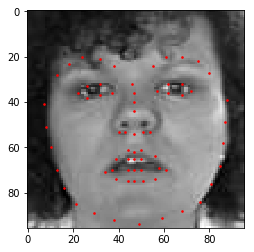

In [1]:
%matplotlib inline
from __future__ import print_function, division
import os
import torch
import sys
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import nn
from torch.autograd import Variable
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv('dataset/train/face_landmarks.csv')

n = 100
img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='red', cmap='rgb')
    plt.pause(0.001)  

plt.figure()
show_landmarks(io.imread(os.path.join('dataset/train/', img_name)),
               landmarks)
plt.show()

In [2]:
def show_landmarks_batch(sample_batch, y_pred=None):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batch['image'], sample_batch['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    print(images_batch.numpy().shape)
    plt.imshow(grid.numpy().transpose(1,0,2).reshape(im_size, -1), cmap="gray")

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r', label='Real')

    if type(y_pred) != type(None):
        for i in range(batch_size):
            plt.scatter(y_pred[i, :, 0] + i * im_size,
                        y_pred[i, :, 1],
                        s=10, marker='.', c='b',  label='Prediction')
        plt.title('Batch from dataloader')
    plt.legend()

In [3]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [5]:
train_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                     root_dir='dataset/train',
                                     transform=ToTensor()
                                     )

test_dataset = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                     root_dir='dataset/test',
                                     transform=ToTensor()
                                     )

In [183]:
train_dataloader = DataLoader(train_dataset, batch_size=64,
                        shuffle=True, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=64,
                        shuffle=True, num_workers=4)

In [184]:
dtype=torch.FloatTensor

def train(network, epochs, learning_rate, loss=nn.MSELoss(), optim=torch.optim.Adam, conv=True):
    train_loss_epochs = []
    test_loss_epochs = []
    optimizer = optim(network.parameters(), lr=learning_rate)
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for sample in train_dataloader:
                X = sample['image']
                if conv:
                    X = Variable(X.view(-1, 1, 96, 96)).type(dtype)
                else:
                    X = Variable(X.view(X.shape[0], -1)).type(dtype)
                
                y = sample['landmarks']
                y = Variable(y.view(y.shape[0], -1)).type(dtype)
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()
  
            train_loss_epochs.append(np.mean(losses))
            losses = []    
            for sample in test_dataloader:
                X = sample['image']
                if conv:
                    X = Variable(X.view(-1, 1, 96, 96)).type(dtype)
                else:
                    X = Variable(X.view(X.shape[0], -1)).type(dtype)
                
                y = sample['landmarks']
                y = Variable(y.view(y.shape[0], -1)).type(dtype)
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                
            test_loss_epochs.append(np.mean(losses))
            sys.stdout.write('\rEpoch {0}... (Train/Test) MSE: {1:.3f}/{2:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.plot(train_loss_epochs[1:], label='Train')
    plt.plot(test_loss_epochs[1:], label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()
    return test_loss_epochs[1:]

In [278]:
def make_summary(labels, values, threshold=12, fontsize=14, rotation=0):
    plt.plot([-1, len(labels)], [threshold, threshold], 'm--', label='MSE={}'.format(threshold))
    plt.bar(labels, values, color='c')
    plt.ylim([0, threshold * 2])
    plt.xlim([-0.7, len(labels) - 0.1])
    plt.ylabel('min test MSE', fontsize=fontsize)
    plt.xticks(fontsize=fontsize, rotation=rotation)
    plt.legend()
    plt.grid()
    plt.show()
    
def plotter(ys, labels, grid=True, fontsize=14, title='', log=False, ylim=None):
    plt.figure(figsize=(8,5))
    for i in range(len(ys)):
        plt.plot(ys[i], label=labels[i])
    plt.ylabel('MSE', fontsize=fontsize)
    plt.xlabel('Epochs', fontsize=fontsize)
    if grid:
        plt.grid()
    if log:
        plt.yscale('log')
    if ylim is not None:
        plt.ylim([ylim[0], ylim[1]])
    plt.legend()
    plt.title(title)
    plt.show()

# Исследование различных архитектур

###  Полносвязные сети

Epoch 99... (Train/Test) MSE: 17.498/18.490823

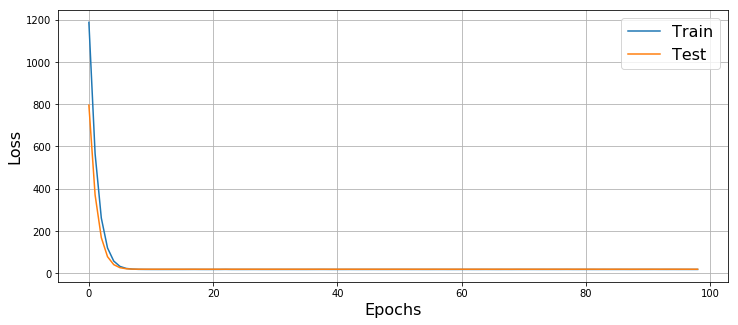

In [168]:
network = nn.Sequential(nn.Linear(1 * 96 * 96, 200),
                        nn.Tanh(),
                        nn.Linear(200, 2 * 68))

FC = train(network, 100, 1e-3, conv=False)

Epoch 14... (Train/Test) MSE: 13.404/15.130373

Exception in thread Thread-3:
Traceback (most recent call last):
  File "/Users/g.gospodinov/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/g.gospodinov/anaconda3/lib/python3.6/site-packages/ipykernel/heartbeat.py", line 61, in run
    zmq.device(zmq.QUEUE, self.socket, self.socket)
  File "zmq/backend/cython/_device.pyx", line 54, in zmq.backend.cython._device.device
  File "zmq/backend/cython/_device.pyx", line 95, in zmq.backend.cython._device.proxy
  File "zmq/backend/cython/checkrc.pxd", line 25, in zmq.backend.cython.checkrc._check_rc
zmq.error.ZMQError: Invalid argument



Epoch 99... (Train/Test) MSE: 3.568/8.67160

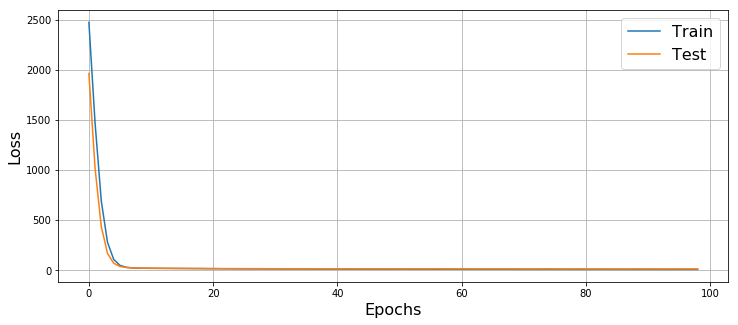

In [185]:
network = nn.Sequential(nn.Linear(1 * 96 * 96, 200),
                        nn.BatchNorm1d(num_features=200),
                        nn.Tanh(),
                        nn.Linear(200, 2 * 68))

FC_BN = train(network, 100, 1e-3, conv=False)

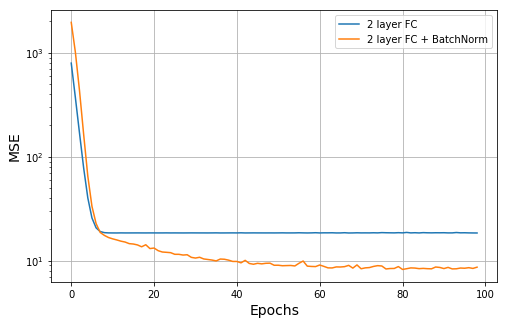

In [279]:
plotter([FC, FC_BN], ['2 layer FC', '2 layer FC + BatchNorm'], log=True)

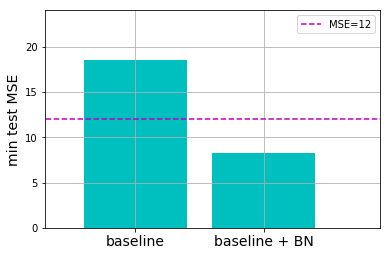

In [195]:
make_summary(['baseline', 'baseline + BN'], [np.min(simple_FC), np.min(modified_FC)])

Слегка улучшенный baseline позволяет добиться MSE < 9 на тестовой выборке. Попробуем улучшить этот результат с помощью сверточных нейронных сетей.

### Сверточные сети

Попробуем применить сеть [Gnet](https://github.com/ga-gospodinov/NeuralNetworks/blob/master/seminar_04/%5BSOLVED%5D%20Practice%20task%204%2C%20CNN.ipynb) , которая хороо зарекомендовала себя на MNIST'e (accuracy > 99%).  

In [196]:
image_size = 96
channels = 1
class model_0(nn.Module):
    def __init__(self, image_size):
        super(model_0, self).__init__()
        self.conv_layers = nn.Sequential(
                                            nn.Conv2d(channels, 8, 5, padding=2), 
                                            nn.ReLU(),
                                            nn.MaxPool2d(2),
                                            nn.Conv2d(8, 16, 5, padding=2),
                                            nn.ReLU(),
                                            nn.MaxPool2d(2),
                                            nn.Conv2d(16, 32, 5, padding=2), 
                                        )
        self.linr_layers = nn.Sequential(
                                            nn.Linear(image_size//4*image_size//4*32, 2*68)                                        
                                        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linr_layers(x) 
        return x

Epoch 49... (Train/Test) MSE: 2.537/6.559717

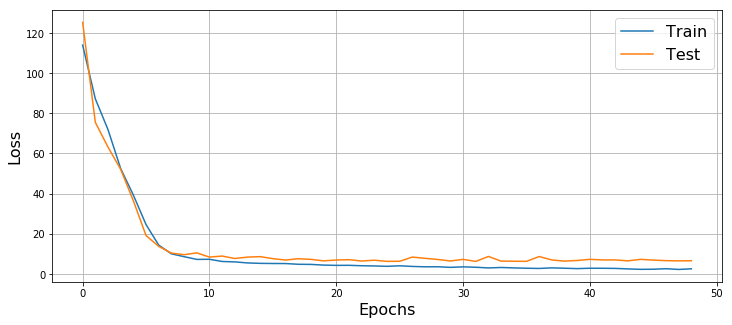

In [197]:
network = model_0(image_size=image_size)
model0_loss = train(network, 50, 1e-3)

Уже улучшили результат полносвязных сетей. Попробуем добавить нормализацию.

Epoch 49... (Train/Test) MSE: 1.227/4.94206

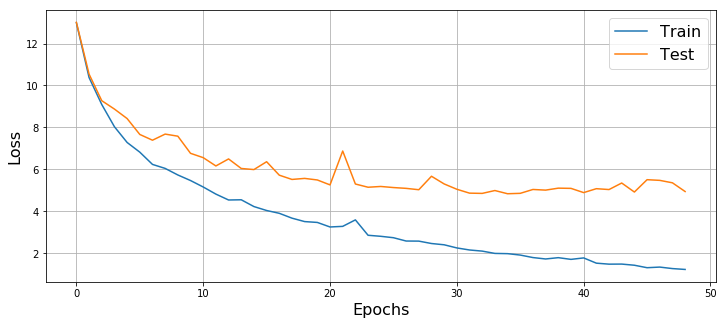

In [199]:
network = model_1(image_size=image_size)
model1_loss = train(network, 50, 1e-3)

Стало лучше, MSE < 5. Попробуем увеличить число сверток.

In [200]:
class model_2(nn.Module):
    def __init__(self, image_size):
        super(model_2, self).__init__()
        self.conv_layers = nn.Sequential(
                                            nn.Conv2d(channels, 32, 3, padding=1),
                                            nn.BatchNorm2d(32),
                                            nn.ReLU(),
                                            nn.MaxPool2d(2),
                                            nn.Conv2d(32, 64, 3, padding=1),
                                            nn.BatchNorm2d(64),
                                            nn.ReLU(),
                                            nn.MaxPool2d(2),
                                            nn.Conv2d(64, 128, 3, padding=1),
                                            nn.BatchNorm2d(128),
                                            nn.ReLU()
                                        )
        self.linr_layers = nn.Sequential(
                                            nn.Linear(image_size//4*image_size//4*128, 2*68)                                        
                                        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linr_layers(x) 
        return x

Epoch 49... (Train/Test) MSE: 0.936/4.29358

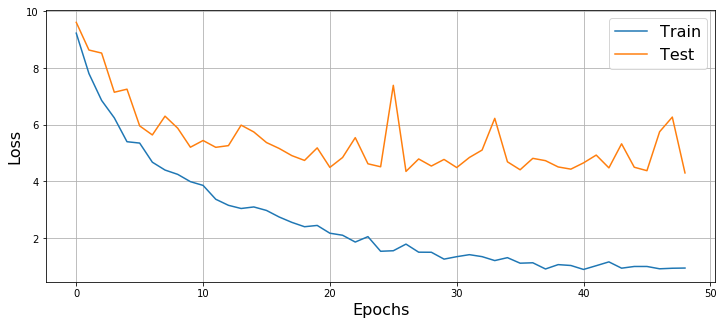

In [202]:
network = model_2(image_size=image_size)
model2_loss = train(network, 50, 1e-3)

Ошибка стала еще меньше, но сеть обучалась несколько часов. Попробуем уменьшить число сверток, но добавить еще один сверточный слой + инициализацию(используем He, которая хороша для ReLU)

In [234]:
class model_3(nn.Module):
    def __init__(self, image_size):
        super(model_3, self).__init__()
        self.conv_layers = nn.Sequential(
                                            nn.Conv2d(channels, 8, 3, padding=1),
                                            nn.BatchNorm2d(8),
                                            nn.ReLU(),
                                            nn.MaxPool2d(2),
                                            nn.Conv2d(8, 16, 3, padding=1),
                                            nn.BatchNorm2d(16),
                                            nn.ReLU(),
                                            nn.MaxPool2d(2),
                                            nn.Conv2d(16, 32, 3, padding=1),
                                            nn.BatchNorm2d(32),
                                            nn.ReLU(),
                                            nn.MaxPool2d(2),
                                            nn.Conv2d(32, 64, 3, padding=1),
                                            nn.BatchNorm2d(64),
                                            nn.ReLU()
                                        )
        self.linr_layers = nn.Sequential(
                                            nn.Linear(image_size//8*image_size//8*64, 2*68)
                                        )
        torch.nn.init.kaiming_normal(self.conv_layers[0].weight)
        torch.nn.init.kaiming_normal(self.conv_layers[4].weight)
        torch.nn.init.kaiming_normal(self.conv_layers[8].weight)
        torch.nn.init.kaiming_normal(self.conv_layers[12].weight)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linr_layers(x) 
        return x

Epoch 49... (Train/Test) MSE: 1.406/4.61097

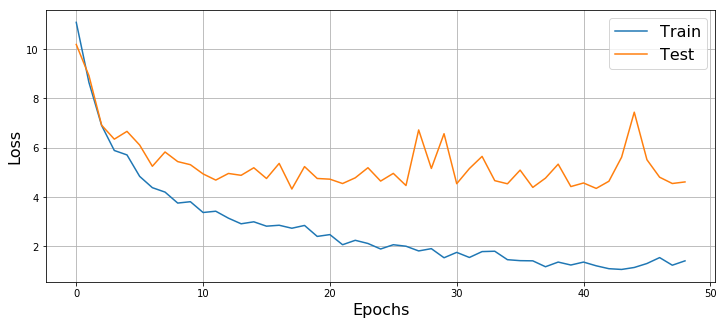

In [235]:
network = model_3(image_size=image_size)
model3_loss = train(network, 50, 1e-2)

С такой архитектурой качество упало не сильно, но обучение ускорилось в разы.

### Результаты

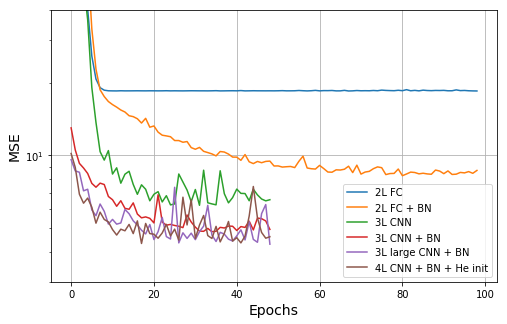

In [283]:
plotter([FC, FC_BN, model0_loss, model1_loss, model2_loss, model3_loss],
        ['2L FC', '2L FC + BN', '3L CNN', '3L CNN + BN', '3L large CNN + BN',
         '4L CNN + BN + He init'], log=True, ylim=[3, 40])

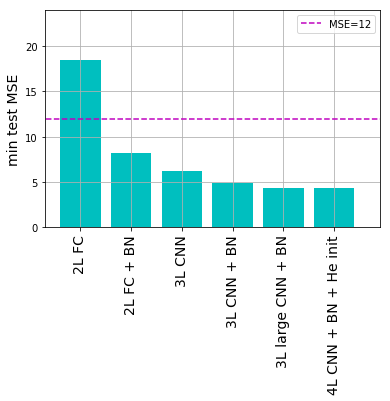

In [257]:
make_summary(['2L FC', '2L FC + BN', '3L CNN', '3L CNN + BN', '3L large CNN + BN', 
              '4L CNN + BN + He init'], [np.min(FC), np.min(FC_BN), np.min(model0_loss),
              np.min(model1_loss), np.min(model2_loss), np.min(model3_loss)], rotation=90)

(2, 96, 96)


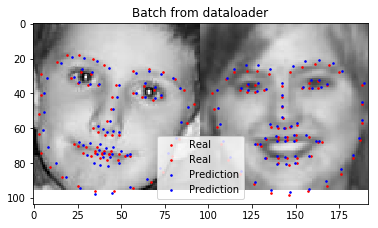

In [265]:
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=4)
batch = next(iter(test_dataloader))
images_batch = batch['image']
x = Variable(images_batch.view(-1, 1, 96, 96).type(dtype))
y_pred = network(x)
y = Variable(batch['landmarks'].view(-1, 68*2).type(dtype))
y_pred = y_pred.view(-1, 68, 2)
y_pred = y_pred.data.numpy()
show_landmarks_batch(batch, y_pred)

### Выводы

Видим, что порог в MSE=12 легко преодолеть простым добавлением нормализации к двухслойной полносвязной сети. Дальнейшее увеличение слоев, эксперименты с активационной функцией и добавление регуляризации не увенчалось успехом.<br>
Из кривых обучения видно, что сверточные сети учатся гораздо быстрее и сходятся к лучшему значению. BatchNorm еще сильнее это ускоряет. Дальнейшее увеличение слоев/количества фильтров к значительному улучшению не привело, но позволило дойти до MSE<4.3. Добавление DropOut, DropConnect, а также дополнительных линейных слоев после сверточных к приросту качества не привело.<br>
Из визуализации ключевых точек видно, что контур лица хорошо определяется, а также сеть хорошо детектирует и наклоненные лица.